In [36]:
import pickle
from Bio import AlignIO, Phylo
from Bio.Phylo.TreeConstruction import DistanceCalculator, DistanceTreeConstructor
from Bio.Align import MultipleSeqAlignment
from Bio.SeqRecord import SeqRecord
from Bio.Seq import Seq
from Bio.Phylo.PhyloXML import Phylogeny
from collections import defaultdict

# Parameters
aligned_fasta_path = r"C:\Users\yegor\Downloads\Galaxy157-[FASTQ to FASTA on data 156_ FASTA].fasta"
start_motif = "TTTTTCCACT"
end_motif = "ACCCGCTGGT"
max_allowed_mismatches = 2
min_slice_length = 1
max_slice_length = 8

# Step 1: Load aligned FASTA
alignment = AlignIO.read(aligned_fasta_path, "fasta")

# Step 2: Extract region between motifs
sliced_sequences = []  # (ID, between-motif sequence)

for rec in alignment:
    full_seq = str(rec.seq).replace("-", "").upper()
    start_idx = full_seq.find(start_motif)
    end_idx = full_seq.find(end_motif)

    if start_idx != -1 and end_idx != -1 and start_idx < end_idx:
        between_seq = full_seq[start_idx + len(start_motif): end_idx]
        if len(between_seq) > 0:
            sliced_sequences.append((rec.id, between_seq))

print(f"✅ Extracted {len(sliced_sequences)} sequences between motifs.")

# Step 3: Group by random region length
length_groups = defaultdict(list)

for record_id, between_seq in sliced_sequences:
    seq_length = len(between_seq)
    length_groups[seq_length].append(SeqRecord(Seq(between_seq), id=record_id, description=""))

# Step 4: Define mismatch-count comparison
def mismatches(seq1, seq2):
    return sum(a != b for a, b in zip(seq1, seq2))

# Step 5: Cluster and collect all representatives
master_cluster_map = {}
master_representatives = []

for slice_len in range(min_slice_length, max_slice_length + 1):
    print(f"\n🔵 Processing random region length: {slice_len} bases")

    if slice_len not in length_groups:
        print(f"⚠️ No sequences of length {slice_len} bases found.")
        continue

    sliced_records = length_groups[slice_len]
    print(f"✅ Found {len(sliced_records)} sequences of length {slice_len} bases.")

    clusters = []
    cluster_map = {}

    for record in sliced_records:
        seq_str = str(record.seq)
        added_to_cluster = False

        for cluster in clusters:
            if all(mismatches(seq_str, str(existing.seq)) <= max_allowed_mismatches for existing in cluster):
                cluster.append(record)
                cluster_map[record.id] = cluster[0].id
                added_to_cluster = True
                break

        if not added_to_cluster:
            clusters.append([record])
            cluster_map[record.id] = record.id

    print(f"✅ Formed {len(clusters)} clusters for region length {slice_len}.")

    # Save cluster map incrementally
    master_cluster_map.update(cluster_map)

    # Collect representatives
    unique_ids = set(cluster_map.values())
    master_representatives.extend(
        [r for r in sliced_records if r.id in unique_ids]
    )

# Step 6: Now PAD representatives after clustering
max_length = max(len(r.seq) for r in master_representatives)
padded_reps = []

for rec in master_representatives:
    seq = str(rec.seq)
    padded_seq = seq.ljust(max_length, "X")  # Pad with 'X' to the right
    padded_reps.append(SeqRecord(Seq(padded_seq), id=rec.id, description=""))

rep_alignment = MultipleSeqAlignment(padded_reps)

print(f"\n✅ Built padded alignment with {len(padded_reps)} sequences, each {max_length} bases long.")

# Step 7: Build NJ tree from padded alignment
calculator = DistanceCalculator("identity")
dm = calculator.get_distance(rep_alignment)
constructor = DistanceTreeConstructor()
nj_tree = constructor.nj(dm)

# Save tree
phyloxml_tree = Phylogeny.from_tree(nj_tree)
Phylo.write(phyloxml_tree, "clustered_tree_combined.xml", "phyloxml")

# Save master cluster map and representatives
with open("combined_cluster_map.pkl", "wb") as f:
    pickle.dump(master_cluster_map, f)
with open("combined_representatives.pkl", "wb") as f:
    pickle.dump([r.id for r in padded_reps], f)

print(f"🎯 Single combined NJ tree and cluster mapping saved successfully!")


✅ Extracted 331 sequences between motifs.

🔵 Processing random region length: 1 bases
✅ Found 4 sequences of length 1 bases.
✅ Formed 1 clusters for region length 1.

🔵 Processing random region length: 2 bases
✅ Found 4 sequences of length 2 bases.
✅ Formed 1 clusters for region length 2.

🔵 Processing random region length: 3 bases
✅ Found 19 sequences of length 3 bases.
✅ Formed 4 clusters for region length 3.

🔵 Processing random region length: 4 bases
✅ Found 13 sequences of length 4 bases.
✅ Formed 4 clusters for region length 4.

🔵 Processing random region length: 5 bases
✅ Found 31 sequences of length 5 bases.
✅ Formed 12 clusters for region length 5.

🔵 Processing random region length: 6 bases
✅ Found 110 sequences of length 6 bases.
✅ Formed 39 clusters for region length 6.

🔵 Processing random region length: 7 bases
✅ Found 108 sequences of length 7 bases.
✅ Formed 48 clusters for region length 7.

🔵 Processing random region length: 8 bases
✅ Found 37 sequences of length 8 bas

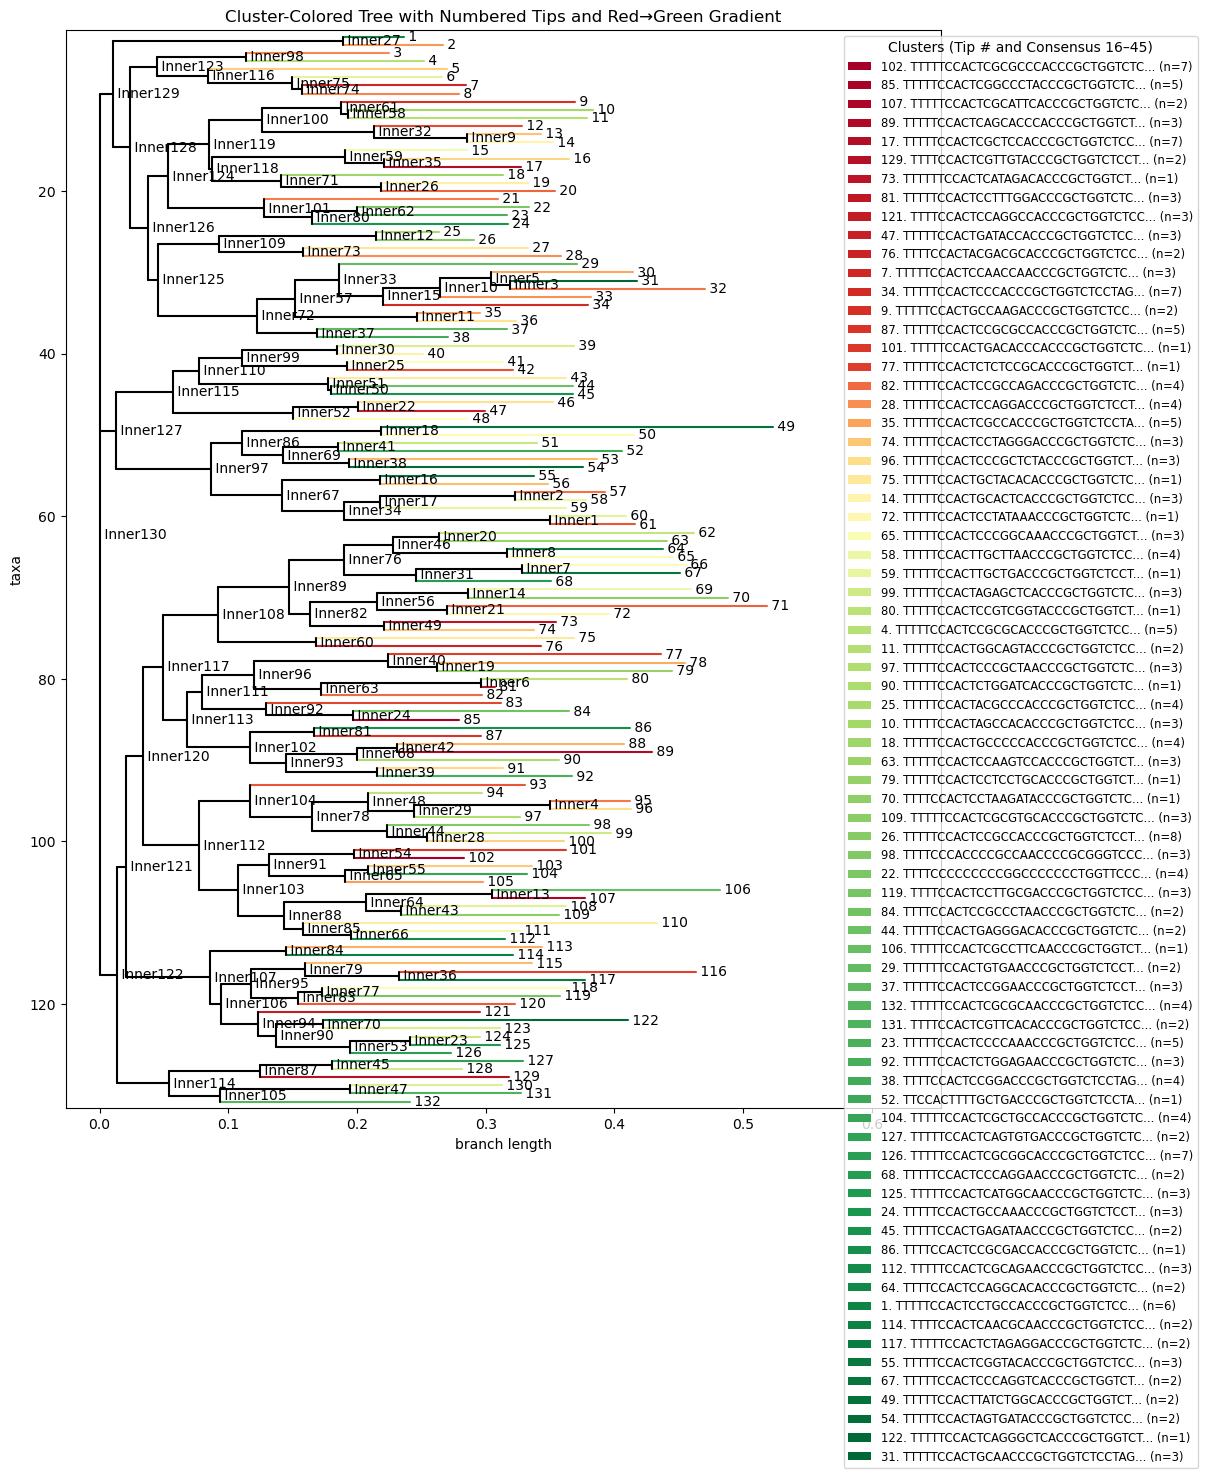


Cluster label numbers:
Cluster 8: Tip #1
Cluster 181: Tip #2
Cluster 178: Tip #3
Cluster 35: Tip #4
Cluster 224: Tip #5
Cluster 305: Tip #6
Cluster 123: Tip #7
Cluster 165: Tip #8
Cluster 127: Tip #9
Cluster 40: Tip #10
Cluster 37: Tip #11
Cluster 137: Tip #12
Cluster 219: Tip #13
Cluster 27: Tip #14
Cluster 290: Tip #15
Cluster 227: Tip #16
Cluster 11: Tip #17
Cluster 41: Tip #18
Cluster 261: Tip #19
Cluster 155: Tip #20
Cluster 164: Tip #21
Cluster 50: Tip #22
Cluster 59: Tip #23
Cluster 73: Tip #24
Cluster 4: Tip #25
Cluster 48: Tip #26
Cluster 246: Tip #27
Cluster 18: Tip #28
Cluster 55: Tip #29
Cluster 195: Tip #30
Cluster 97: Tip #31
Cluster 162: Tip #32
Cluster 180: Tip #33
Cluster 126: Tip #34
Cluster 19: Tip #35
Cluster 244: Tip #36
Cluster 56: Tip #37
Cluster 61: Tip #38
Cluster 318: Tip #39
Cluster 264: Tip #40
Cluster 287: Tip #41
Cluster 139: Tip #42
Cluster 252: Tip #43
Cluster 53: Tip #44
Cluster 74: Tip #45
Cluster 240: Tip #46
Cluster 119: Tip #47
Cluster 286: Tip #48

In [43]:
from Bio import Phylo
from Bio.Phylo.PhyloXML import BranchColor
from collections import defaultdict, Counter
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib import colormaps
import pickle
from Bio import AlignIO

# --- Parameters ---
tree_file = "clustered_tree_combined.xml"
cluster_map_file = "combined_cluster_map.pkl"
alignment_file = r"C:\Users\yegor\Downloads\Galaxy157-[FASTQ to FASTA on data 156_ FASTA].fasta"

# --- Load tree and cluster map ---
tree = Phylo.read(tree_file, "phyloxml")

with open(cluster_map_file, "rb") as f:
    cluster_map = pickle.load(f)

# --- Step 1: Rebuild cluster_to_members from cluster_map ---
cluster_to_members = defaultdict(list)
for seq_id, rep_id in cluster_map.items():
    cluster_to_members[rep_id].append(seq_id)

# --- Step 2: Index the original alignment ---
alignment = AlignIO.read(alignment_file, "fasta")
seq_id_to_record = {rec.id: rec for rec in alignment}

# --- Step 3: Compute majority-rule consensus per cluster ---
def majority_consensus(seqs):
    if not seqs:
        return ""
    length = len(seqs[0])
    consensus = []
    for i in range(length):
        bases = [seq[i] for seq in seqs if len(seq) > i]
        base_counts = Counter(bases)
        most_common = base_counts.most_common(1)[0][0]
        consensus.append(most_common)
    return ''.join(consensus)

cluster_to_consensus = {}
for cluster, seq_ids in cluster_to_members.items():
    seqs = [
        str(seq_id_to_record[sid].seq).replace("-", "")
        for sid in seq_ids if sid in seq_id_to_record
    ]
    if seqs:
        consensus = majority_consensus(seqs)
        cluster_to_consensus[cluster] = consensus

# --- Step 4: Assign red→green color gradient to clusters ---
seq_to_cluster = {
    sid: cluster for cluster, members in cluster_to_members.items() for sid in members
}

cluster_list = sorted(cluster_to_members.keys())
cmap = colormaps.get_cmap("RdYlGn")
colors = [cmap(i / (len(cluster_list) - 1)) for i in range(len(cluster_list))]
cluster_to_color = {}

for cluster, rgba in zip(cluster_list, colors):
    rgb255 = tuple(int(c * 255) for c in rgba[:3])
    cluster_to_color[cluster] = BranchColor(*rgb255)

# --- Step 5: Assign color and numeric label to each terminal clade ---
cluster_to_label_number = {}  # maps cluster → lowest clade number
for i, clade in enumerate(tree.get_terminals(), start=1):
    original_cluster = seq_to_cluster.get(clade.name)
    if original_cluster:
        clade.color = cluster_to_color[original_cluster]
        if original_cluster not in cluster_to_label_number:
            cluster_to_label_number[original_cluster] = i
    clade.name = str(i)  # numeric tip label

# --- Step 6: Plot tree and build numbered legend ---
fig, ax = plt.subplots(figsize=(14, 14))
Phylo.draw(tree, axes=ax, do_show=False)

legend_elements = []

# Find clusters that actually appear in the tree (filter out None safely)
clusters_in_tree = set(
    cluster for clade in tree.get_terminals()
    if clade.name.isdigit()
    for cluster in [seq_to_cluster.get(clade.name)]
    if cluster is not None
)

# Now build the legend
for cluster in sorted(clusters_in_tree):
    color = cluster_to_color.get(cluster)
    if color:
        rgb = (color.red / 255, color.green / 255, color.blue / 255)
        consensus = cluster_to_consensus.get(cluster, "Unknown")
        count = len(cluster_to_members.get(cluster, []))
        snippet = consensus[15:45] if len(consensus) > 15 else consensus
        num_label = cluster_to_label_number.get(cluster, "?")
        label = f"{num_label}. {snippet}... (n={count})" if len(snippet) == 30 else f"{num_label}. {snippet} (n={count})"
        legend_elements.append(Patch(facecolor=rgb, label=label))

# Plot the legend
ax.legend(
    handles=legend_elements,
    title="Clusters (Tip # and Consensus 16–45)",
    loc="upper right",
    bbox_to_anchor=(1.3, 1),
    fontsize="small",
    title_fontsize="medium"
)

plt.title("Cluster-Colored Tree with Numbered Tips and Red→Green Gradient")
plt.subplots_adjust(right=0.75)
plt.show()

# --- Print final mapping of cluster → numeric label ---
print("\nCluster label numbers:")
for cluster, number in cluster_to_label_number.items():
    print(f"Cluster {cluster}: Tip #{number}")


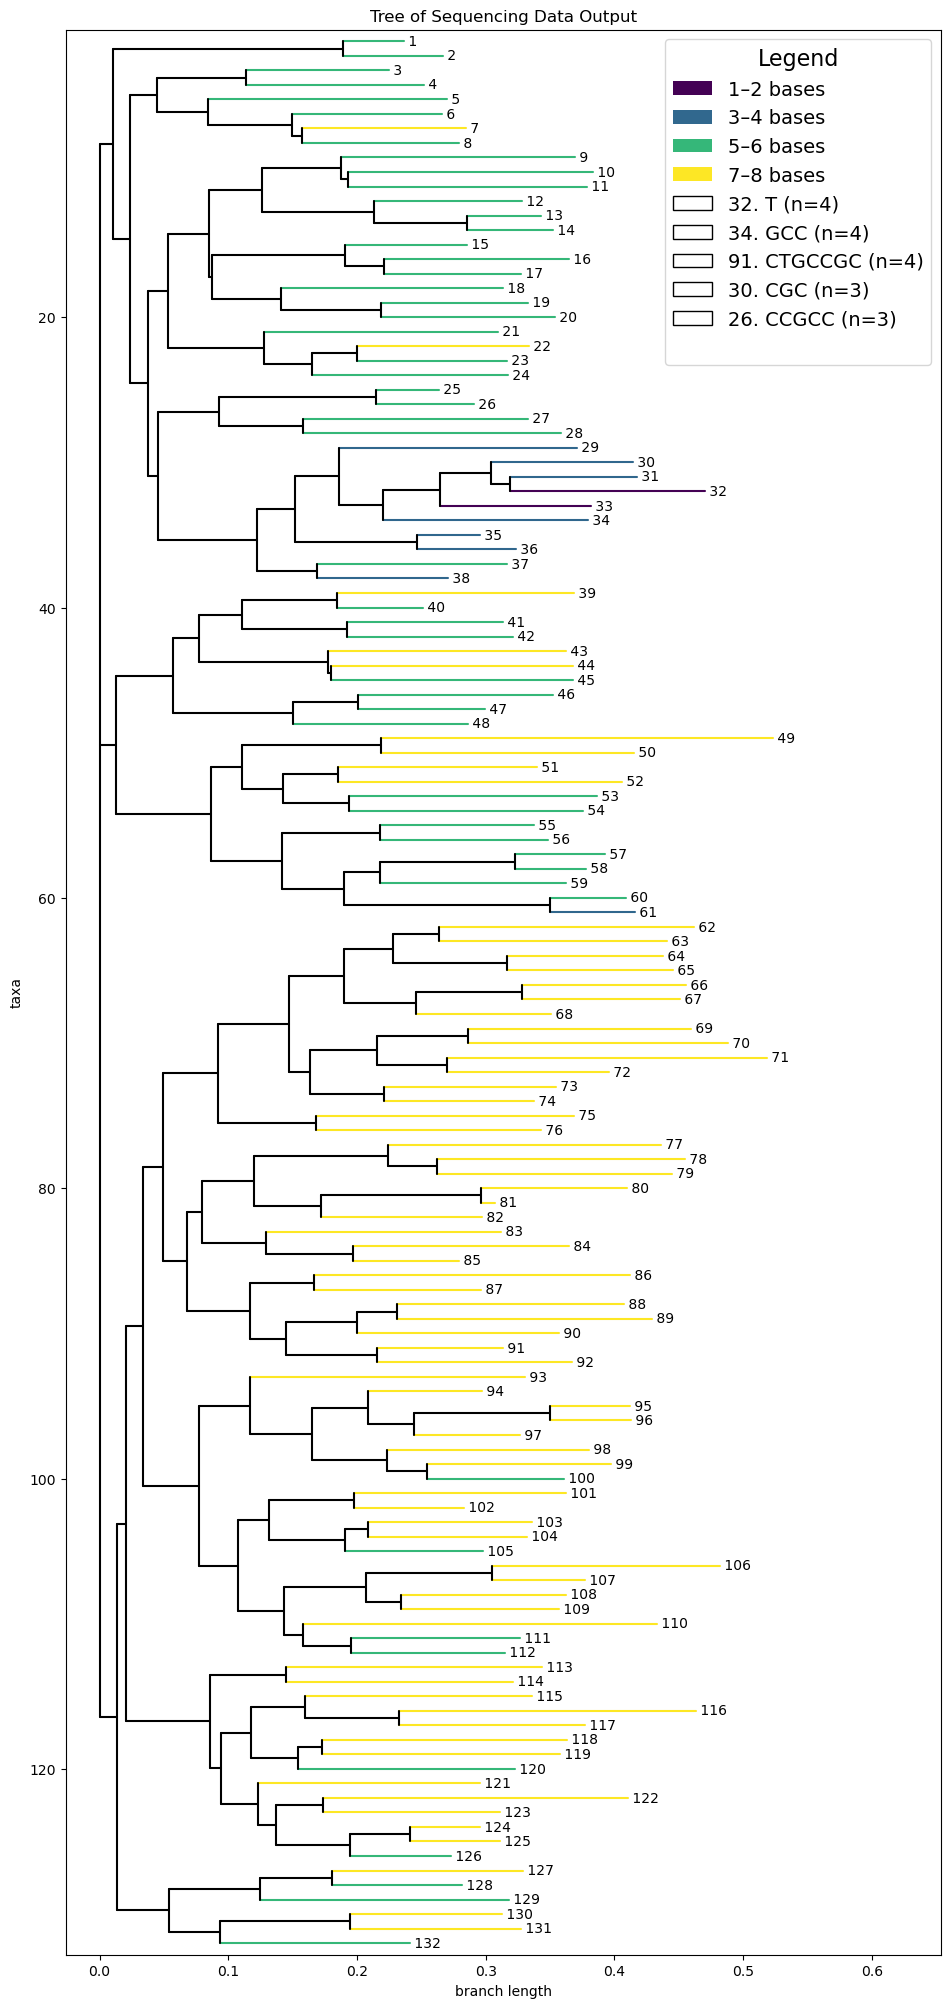

In [18]:
from Bio import Phylo
from Bio.Phylo.PhyloXML import BranchColor
from collections import defaultdict, Counter
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib import colormaps
import pickle
from Bio import AlignIO

# --- Parameters ---
tree_file = "clustered_tree_combined.xml"
cluster_map_file = "combined_cluster_map.pkl"
alignment_file = r"C:\Users\yegor\Downloads\Galaxy157-[FASTQ to FASTA on data 156_ FASTA].fasta"
motif_start = "TTTTTCCACT"
motif_end = "ACCCGCTGGT"

# --- Load tree and cluster map ---
tree = Phylo.read(tree_file, "phyloxml")

with open(cluster_map_file, "rb") as f:
    cluster_map = pickle.load(f)

# --- Step 1: Rebuild cluster_to_members from cluster_map ---
cluster_to_members = defaultdict(list)
for seq_id, rep_id in cluster_map.items():
    cluster_to_members[rep_id].append(seq_id)

# --- Step 2: Index the original alignment ---
alignment = AlignIO.read(alignment_file, "fasta")
seq_id_to_record = {rec.id: rec for rec in alignment}

# --- Step 3: Compute random region length per cluster ---
cluster_to_random_region_length = {}

for cluster, seq_ids in cluster_to_members.items():
    example_id = seq_ids[0]
    rec = seq_id_to_record.get(example_id)
    if rec:
        real_seq = str(rec.seq).replace("-", "").upper()
        idx_start = real_seq.find(motif_start)
        idx_end = real_seq.find(motif_end)
        if idx_start != -1 and idx_end != -1 and idx_start < idx_end:
            random_region = real_seq[idx_start + len(motif_start): idx_end]
            region_length = len(random_region)
            if 1 <= region_length <= 8:  # Only keep valid lengths
                cluster_to_random_region_length[cluster] = region_length
            else:
                cluster_to_random_region_length[cluster] = None
        else:
            cluster_to_random_region_length[cluster] = None
    else:
        cluster_to_random_region_length[cluster] = None

# --- Step 4: Assign color based on grouped random region length ---

# Map each length into a group
def length_to_group(length):
    if 1 <= length <= 2:
        return 1  # Group 1–2
    elif 3 <= length <= 4:
        return 2  # Group 3–4
    elif 5 <= length <= 6:
        return 3  # Group 5–6
    elif 7 <= length <= 8:
        return 4  # Group 7–8
    else:
        return None

cluster_to_group = {}
for cluster, region_length in cluster_to_random_region_length.items():
    if region_length is not None:
        group = length_to_group(region_length)
        cluster_to_group[cluster] = group
    else:
        cluster_to_group[cluster] = None

# Assign color per group
groups_used = sorted(set(g for g in cluster_to_group.values() if g is not None))
cmap = colormaps.get_cmap("viridis")  # Plasma looks cleaner than viridis here
max_idx = len(groups_used) - 1

cluster_to_color = {}

for cluster, group in cluster_to_group.items():
    if group is not None:
        idx = groups_used.index(group)
        rgba = cmap(idx / max_idx if max_idx > 0 else 0)
        rgb255 = tuple(int(c * 255) for c in rgba[:3])
        cluster_to_color[cluster] = BranchColor(*rgb255)
    else:
        cluster_to_color[cluster] = BranchColor(150, 150, 150)  # grey if missing

# --- Step 5: Assign color and numeric label to each terminal clade ---
seq_to_cluster = {
    sid: cluster for cluster, members in cluster_to_members.items() for sid in members
}

cluster_to_label_number = {}

for i, clade in enumerate(tree.get_terminals(), start=1):
    original_cluster = seq_to_cluster.get(clade.name)
    if original_cluster:
        clade.color = cluster_to_color[original_cluster]
        if original_cluster not in cluster_to_label_number:
            cluster_to_label_number[original_cluster] = i
    clade.name = str(i)  # numeric tip label

# Remove internal node labels
for clade in tree.get_nonterminals():
    clade.name = None

# --- Step 6: Plot tree and build numbered legend ---
fig, ax = plt.subplots(figsize=(14, 25))  # Taller figure for better label spacing
Phylo.draw(tree, axes=ax, do_show=False)

# --- Build Legend ---
legend_elements = []

group_labels = {
    1: "1–2 bases",
    2: "3–4 bases",
    3: "5–6 bases",
    4: "7–8 bases"
}

for group in groups_used:
    idx = groups_used.index(group)
    rgba = cmap(idx / max_idx if max_idx > 0 else 0)
    rgb = tuple(rgba[:3])
    label = group_labels.get(group, f"Group {group}")
    legend_elements.append(Patch(facecolor=rgb, label=label))

# --- Add the 5 most common random regions (real sequences, with clade number and n) ---

# Step 1: Collect all random regions and their clade numbers
random_region_records = []

for cluster, seq_ids in cluster_to_members.items():
    for seq_id in seq_ids:
        rec = seq_id_to_record.get(seq_id)
        if rec:
            real_seq = str(rec.seq).replace("-", "").upper()
            idx_start = real_seq.find(motif_start)
            idx_end = real_seq.find(motif_end)
            if idx_start != -1 and idx_end != -1 and idx_start < idx_end:
                random_region = real_seq[idx_start + len(motif_start): idx_end]
                if 1 <= len(random_region) <= 8:
                    clade_num = cluster_to_label_number.get(seq_to_cluster.get(seq_id), "?")
                    random_region_records.append((random_region, clade_num))

# Step 2: Count random region occurrences
from collections import Counter
random_region_counts = Counter(region for region, _ in random_region_records)

# Step 3: Find top 5 most common random regions
top5_regions = random_region_counts.most_common(5)

# Step 4: Build the legend entries
for random_region, count in top5_regions:
    # Find one clade number example for this random region
    matching_clade = next(
        (clade_num for region, clade_num in random_region_records if region == random_region),
        "?"
    )
    label = f"{matching_clade}. {random_region} (n={count})"
    legend_elements.append(Patch(facecolor="white", edgecolor="black", label=label))# --- Build the legend elements ---


# Insert an empty line after the color groups
legend_elements.append(Patch(facecolor="white", edgecolor="white", label=" "))

# --- Finalize legend ---
ax.legend(
    handles=legend_elements,
    loc="upper right",
    bbox_to_anchor=(1, 1),
    fontsize=14,
    title="Legend",
    title_fontsize=16
)

# --- Finalize ---
plt.title("Tree of Sequencing Data Output")
plt.subplots_adjust(right=0.75)
plt.savefig(r"C:\Users\yegor\Downloads\final_tree.png", dpi=300, bbox_inches="tight")
plt.show()

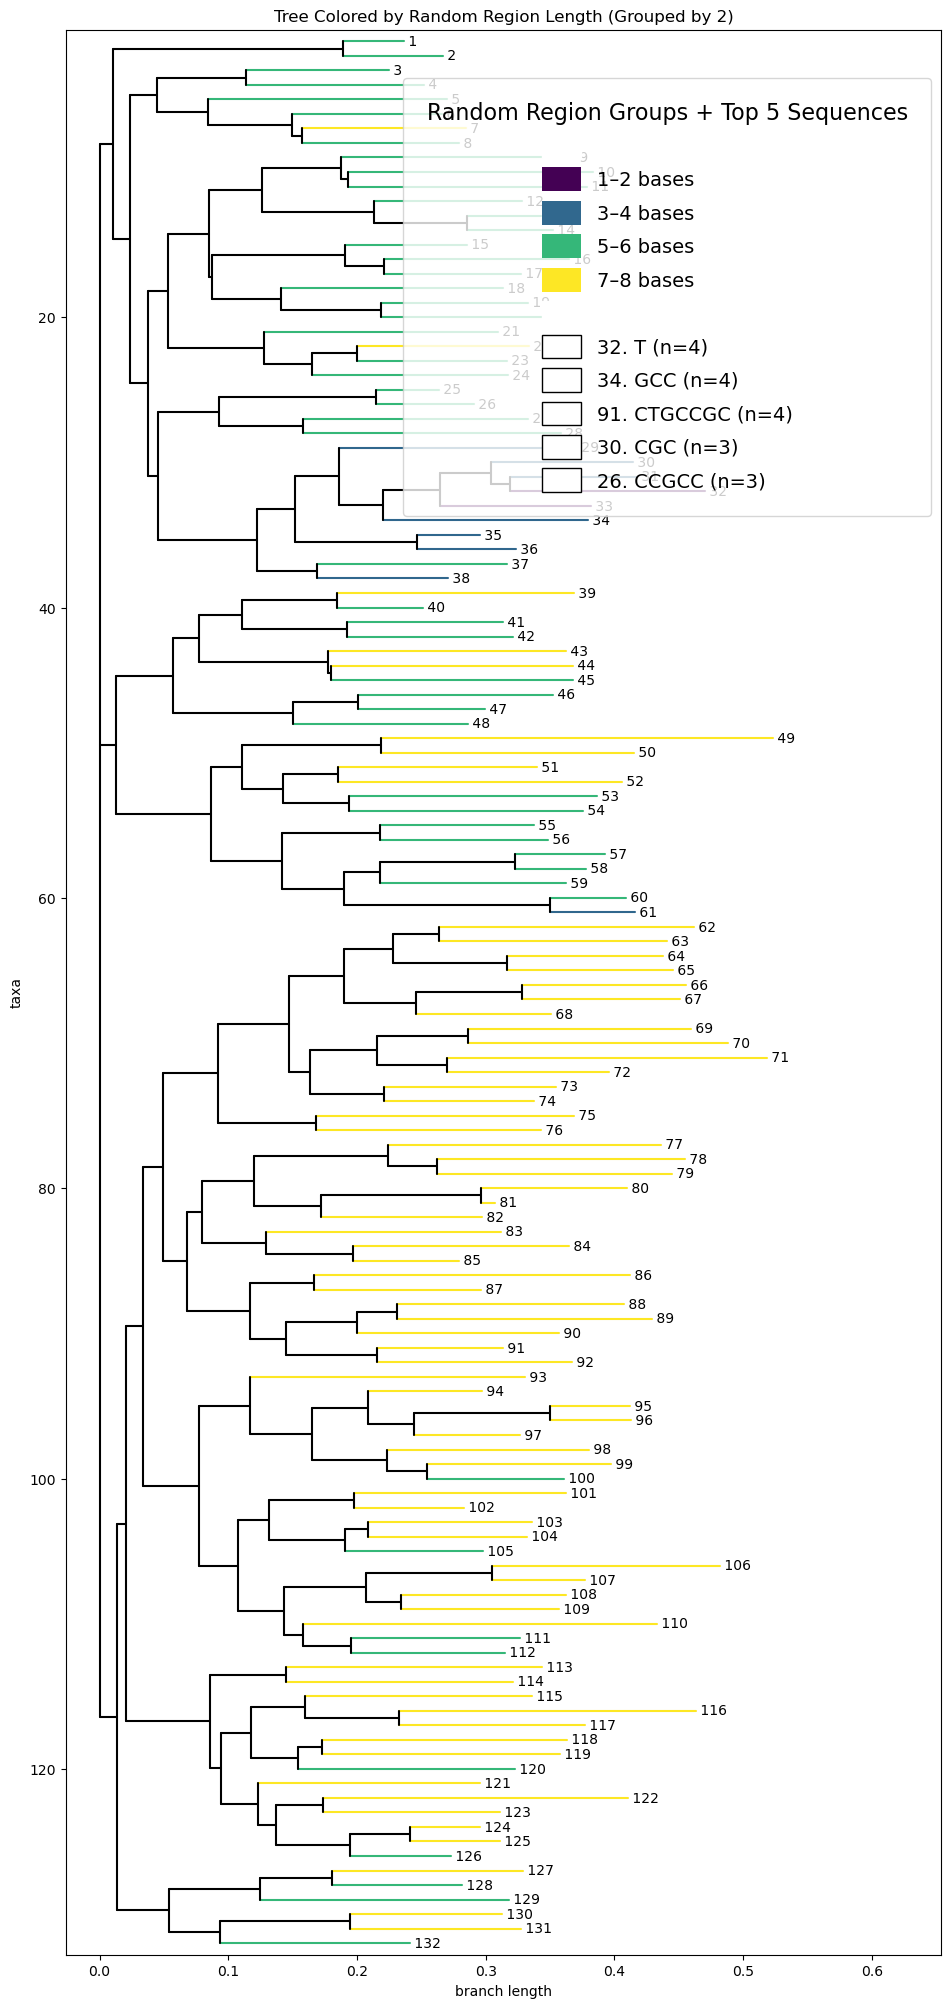

In [153]:
from Bio import Phylo
from Bio.Phylo.PhyloXML import BranchColor
from collections import defaultdict, Counter
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib import colormaps
import pickle
from Bio import AlignIO

# --- Parameters ---
tree_file = "clustered_tree_combined.xml"
cluster_map_file = "combined_cluster_map.pkl"
alignment_file = r"C:\Users\yegor\Downloads\Galaxy157-[FASTQ to FASTA on data 156_ FASTA].fasta"
motif_start = "TTTTTCCACT"
motif_end = "ACCCGCTGGT"

# --- Load tree and cluster map ---
tree = Phylo.read(tree_file, "phyloxml")

with open(cluster_map_file, "rb") as f:
    cluster_map = pickle.load(f)

# --- Step 1: Rebuild cluster_to_members from cluster_map ---
cluster_to_members = defaultdict(list)
for seq_id, rep_id in cluster_map.items():
    cluster_to_members[rep_id].append(seq_id)

# --- Step 2: Index the original alignment ---
alignment = AlignIO.read(alignment_file, "fasta")
seq_id_to_record = {rec.id: rec for rec in alignment}

# --- Step 3: Compute random region length per cluster ---
cluster_to_random_region_length = {}

for cluster, seq_ids in cluster_to_members.items():
    example_id = seq_ids[0]
    rec = seq_id_to_record.get(example_id)
    if rec:
        real_seq = str(rec.seq).replace("-", "").upper()
        idx_start = real_seq.find(motif_start)
        idx_end = real_seq.find(motif_end)
        if idx_start != -1 and idx_end != -1 and idx_start < idx_end:
            random_region = real_seq[idx_start + len(motif_start): idx_end]
            region_length = len(random_region)
            if 1 <= region_length <= 8:
                cluster_to_random_region_length[cluster] = region_length
            else:
                cluster_to_random_region_length[cluster] = None
        else:
            cluster_to_random_region_length[cluster] = None
    else:
        cluster_to_random_region_length[cluster] = None

# --- Step 4: Assign color based on grouped random region length ---
def length_to_group(length):
    if 1 <= length <= 2:
        return 1
    elif 3 <= length <= 4:
        return 2
    elif 5 <= length <= 6:
        return 3
    elif 7 <= length <= 8:
        return 4
    else:
        return None

cluster_to_group = {}
for cluster, region_length in cluster_to_random_region_length.items():
    if region_length is not None:
        group = length_to_group(region_length)
        cluster_to_group[cluster] = group
    else:
        cluster_to_group[cluster] = None

groups_used = sorted(set(g for g in cluster_to_group.values() if g is not None))
cmap = colormaps.get_cmap("viridis")
max_idx = len(groups_used) - 1

cluster_to_color = {}
for cluster, group in cluster_to_group.items():
    if group is not None:
        idx = groups_used.index(group)
        rgba = cmap(idx / max_idx if max_idx > 0 else 0)
        rgb255 = tuple(int(c * 255) for c in rgba[:3])
        cluster_to_color[cluster] = BranchColor(*rgb255)
    else:
        cluster_to_color[cluster] = BranchColor(150, 150, 150)

# --- Step 5: Assign color and numeric label to each terminal clade ---
seq_to_cluster = {sid: cluster for cluster, members in cluster_to_members.items() for sid in members}

cluster_to_label_number = {}

for i, clade in enumerate(tree.get_terminals(), start=1):
    original_cluster = seq_to_cluster.get(clade.name)
    if original_cluster:
        clade.color = cluster_to_color.get(original_cluster)
        if original_cluster not in cluster_to_label_number:
            cluster_to_label_number[original_cluster] = i
    clade.name = str(i)  # Numeric tip label

# --- Manual corrections ---
cluster_to_label_number[34] = 80
cluster_to_label_number[32] = 99
cluster_to_label_number[30] = 59
cluster_to_label_number[91] = 54

# Remove internal node labels
for clade in tree.get_nonterminals():
    clade.name = None

# --- Step 6: Plot tree and build legend ---
fig, ax = plt.subplots(figsize=(14, 25))
Phylo.draw(tree, axes=ax, do_show=False)

# --- Build Legend ---
legend_elements = []

# --- First: Random region length groups ---
group_labels = {
    1: "1–2 bases",
    2: "3–4 bases",
    3: "5–6 bases",
    4: "7–8 bases"
}

legend_elements.append(Patch(facecolor="white", edgecolor="white", label=" "))
for group in groups_used:
    idx = groups_used.index(group)
    rgba = cmap(idx / max_idx if max_idx > 0 else 0)
    rgb = tuple(rgba[:3])
    label = group_labels.get(group, f"Group {group}")
    legend_elements.append(Patch(facecolor=rgb, label=label))

# --- Empty line ---
legend_elements.append(Patch(facecolor="white", edgecolor="white", label=" "))

# --- Top 5 most common random regions using corrected tip numbers ---
random_region_records = []

for cluster, seq_ids in cluster_to_members.items():
    for seq_id in seq_ids:
        rec = seq_id_to_record.get(seq_id)
        if rec:
            real_seq = str(rec.seq).replace("-", "").upper()
            idx_start = real_seq.find(motif_start)
            idx_end = real_seq.find(motif_end)
            if idx_start != -1 and idx_end != -1 and idx_start < idx_end:
                random_region = real_seq[idx_start + len(motif_start): idx_end]
                if 1 <= len(random_region) <= 8:
                    tip_number = cluster_to_label_number.get(cluster, "?")
                    random_region_records.append((random_region, tip_number))

# Step 2: Count (random_region, tip_number) pairs
random_region_counts = Counter(random_region_records)

# Step 3: Find top 5
top5_regions = random_region_counts.most_common(5)

# Step 4: Add Top 5 entries to legend
for (random_region, tip_number), count in top5_regions:
    label = f"{tip_number}. {random_region} (n={count})"
    legend_elements.append(Patch(facecolor="white", edgecolor="black", label=label))

# --- Finalize legend ---
ax.legend(
    handles=legend_elements,
    loc="upper right",
    bbox_to_anchor=(1, 0.98),
    fontsize=14,
    title="Random Region Groups + Top 5 Sequences",
    title_fontsize=16,
    handleheight=1.5,
    borderpad=1.2
)

# --- Finalize plot ---
plt.title("Tree Colored by Random Region Length (Grouped by 2)")
plt.subplots_adjust(right=0.75)
plt.show()


In [172]:
from collections import Counter

# Define ANSI color map
base_colors = {
    "A": "\033[92m",  # Green
    "T": "\033[91m",  # Red
    "C": "\033[94m",  # Blue
    "G": "\033[33m",  # Orange
    "N": "\033[90m",
    "-": "\033[90m",
}
reset = "\033[0m"

# Invert the tip-to-cluster mapping
label_number_to_cluster = {v: k for k, v in cluster_to_label_number.items()}

# Input the tip number
tip_number = 89  # clade label
rep_id = label_number_to_cluster[tip_number]

# Set motif and extraction window
motif = "TTTTTCCAC"
window = 15

# Collect all sequences in this clade
sequences = []
window_counts = Counter()
for seq_id in cluster_to_members[rep_id]:
    raw_seq = str(seq_id_to_record[seq_id].seq).replace("-", "").strip().upper()
    sequences.append((seq_id, raw_seq))
    idx = raw_seq.find(motif)
    if idx != -1 and idx + len(motif) + window <= len(raw_seq):
        sub = raw_seq[idx + len(motif): idx + len(motif) + window]
        window_counts[sub] += 1

# Most common 15-mer following the motif
if window_counts:
    top_sub, count = window_counts.most_common(1)[0]
    print(f"\n🧬 Sequences in clade {tip_number} (rep ID: {rep_id})")
    print(f"🔥 Most common 10-mer after '{motif}': {top_sub} (n={count})\n")
else:
    print(f"\n🧬 Sequences in clade {tip_number} (rep ID: {rep_id})")
    print(f"⚠️ Motif '{motif}' not found in sequences.\n")

# Print all colored sequences
for seq_id, raw_seq in sequences:
    colored_seq = "".join(base_colors.get(base, "") + base + reset for base in raw_seq)
    print(f">{seq_id}\n{colored_seq}")



🧬 Sequences in clade 89 (rep ID: 104)
🔥 Most common 10-mer after 'TTTTTCCAC': TCAGCACCCACCCGC (n=2)

>104
CTTTTTTTTTTTTTTTTTTCCACTCTGAACCCACCCGCTGGTCTCCTAGACTCTTCGGAGAGATCGGAAGAGCACACGTCTGAACTCCAGTCACATCACGATCTGGCATTCCGTCTTTTGCTTCAGAGAAGGGGGGGGGGGGGGGGGGGGG
>105
TTTTTTTTTTTTTTTTTTTTCCACTCAGCACCCACCCGCTGGTCTCCTAGACTCTTCGGAGAGATCGGAAGAGCACACGTCTGAACTCCAGTCACATCACGATCTTGTATACCGTCTTTTGCGTCGGAGAAGGGGGGGGGGGGGGGGGGGG
>106
TTTTTTTTTTTTTTTTTTTTCCACTCAGCACCCACCCGCTGGTCTCCTAGACTCTTCGGAGAGATCGGAAGAGCACACGTCTGAACTCCAGTCACATCACGATCTTGTATACCGACTTTTGCTTTGGAGACGGGGGGGGGGGGGGGGGGGG


In [59]:
motif_start = "TTTTTCCACT"
motif_end = "ACCCGCTGGT"

print("\n🎨 Colored consensus slices BETWEEN 'TTTTTCC' and 'ACCCGCTGGT' (rebuilding consensus from random regions only):\n")

def majority_consensus(seqs):
    if not seqs:
        return ""
    length = len(seqs[0])
    consensus = []
    for i in range(length):
        bases = [seq[i] for seq in seqs if len(seq) > i]
        base_counts = Counter(bases)
        most_common = base_counts.most_common(1)[0][0]
        consensus.append(most_common)
    return ''.join(consensus)

for cluster, member_ids in cluster_to_members.items():
    label_num = cluster_to_label_number.get(cluster, "?")
    cluster_size = len(member_ids)

    random_regions = []

    for seq_id in member_ids:
        rec = seq_id_to_record.get(seq_id)
        if rec:
            real_seq = str(rec.seq).replace("-", "").upper()
            idx_start = real_seq.find(motif_start)
            idx_end = real_seq.find(motif_end)

            if idx_start != -1 and idx_end != -1 and idx_start < idx_end:
                random_region = real_seq[idx_start + len(motif_start) : idx_end]
                random_regions.append(random_region)

    if random_regions:
        # Build consensus only from random regions
        consensus_random_region = majority_consensus(random_regions)

        colored_seq = "".join(
            base_colors.get(base.upper(), "") + base.upper() + reset for base in consensus_random_region
        )

        print(f"Cluster {label_num} (n={cluster_size}): {colored_seq}")
    else:
        print(f"Cluster {label_num} (n={cluster_size}): Motifs not found in any member.")



🎨 Colored consensus slices BETWEEN 'TTTTTCC' and 'ACCCGCTGGT' (rebuilding consensus from random regions only):

Cluster 32 (n=4): T
Cluster 33 (n=4): CT
Cluster 31 (n=3): GCA
Cluster 34 (n=7): GCC
Cluster 30 (n=5): CGC
Cluster 36 (n=4): CGG
Cluster 35 (n=5): CGCC
Cluster 29 (n=2): GTGA
Cluster 38 (n=4): CCGG
Cluster 61 (n=2): TTTT
Cluster 28 (n=4): CCAGG
Cluster 59 (n=1): TGCTG
Cluster 26 (n=8): GCGCC
Cluster 37 (n=3): CCGGA
Cluster 24 (n=3): GCCAA
Cluster 20 (n=2): AGCCC
Cluster 8 (n=4): CCAAC
Cluster 2 (n=2): CTTGC
Cluster 56 (n=1): TGGGA
Cluster 19 (n=1): GGCGC
Cluster 48 (n=1): CATAA
Cluster 60 (n=1): TTTTT
Cluster 58 (n=4): TGCTTA
Cluster 25 (n=4): ACGCCC
Cluster 1 (n=6): CCTGCC
Cluster 17 (n=7): GGCTCC
Cluster 14 (n=3): GCACTC
Cluster 4 (n=5): CCGCGC
Cluster 11 (n=2): GGCAGT
Cluster 10 (n=3): AGCCAC
Cluster 18 (n=4): GCCCCC
Cluster 132 (n=4): CCGGCA
Cluster 23 (n=5): CCACAA
Cluster 126 (n=7): CGCGGC
Cluster 45 (n=2): GAGATA
Cluster 112 (n=3): CGCACG
Cluster 55 (n=3): CGGTAC
Clus

In [13]:
# List of input sequences
input_seqs = [
    "GCC", "CGC", "CCGG", "CCGCC", "CCAAC", "CCTGCC", "CGCTCC", "CCACAA", "CACGGC", "GCGTCA",
    "CGCGGCC", "CGGCCCT", "CGCTGCC", "CTGCCGC", "CCCGCTCT", "CCAAGCAA","CCAAGTCC","CAGCACCC"]

# Fixed sequences
prefix = "CCACT"
suffix = "ACCCGCUGGUCUCCUAGACUCUUCGGAGUCUAGGAGACCA"

# Process each input
output_seqs = []
for seq in input_seqs:
    final_seq = prefix + seq + suffix
    output_seqs.append(final_seq)

# Output results with numbering
for idx, (original, final) in enumerate(zip(input_seqs, output_seqs), start=1):
    print(f"RNA {idx}: {final}")


RNA 1: CCACTGCCACCCGCUGGUCUCCUAGACUCUUCGGAGUCUAGGAGACCA
RNA 2: CCACTCGCACCCGCUGGUCUCCUAGACUCUUCGGAGUCUAGGAGACCA
RNA 3: CCACTCCGGACCCGCUGGUCUCCUAGACUCUUCGGAGUCUAGGAGACCA
RNA 4: CCACTCCGCCACCCGCUGGUCUCCUAGACUCUUCGGAGUCUAGGAGACCA
RNA 5: CCACTCCAACACCCGCUGGUCUCCUAGACUCUUCGGAGUCUAGGAGACCA
RNA 6: CCACTCCTGCCACCCGCUGGUCUCCUAGACUCUUCGGAGUCUAGGAGACCA
RNA 7: CCACTCGCTCCACCCGCUGGUCUCCUAGACUCUUCGGAGUCUAGGAGACCA
RNA 8: CCACTCCACAAACCCGCUGGUCUCCUAGACUCUUCGGAGUCUAGGAGACCA
RNA 9: CCACTCACGGCACCCGCUGGUCUCCUAGACUCUUCGGAGUCUAGGAGACCA
RNA 10: CCACTGCGTCAACCCGCUGGUCUCCUAGACUCUUCGGAGUCUAGGAGACCA
RNA 11: CCACTCGCGGCCACCCGCUGGUCUCCUAGACUCUUCGGAGUCUAGGAGACCA
RNA 12: CCACTCGGCCCTACCCGCUGGUCUCCUAGACUCUUCGGAGUCUAGGAGACCA
RNA 13: CCACTCGCTGCCACCCGCUGGUCUCCUAGACUCUUCGGAGUCUAGGAGACCA
RNA 14: CCACTCTGCCGCACCCGCUGGUCUCCUAGACUCUUCGGAGUCUAGGAGACCA
RNA 15: CCACTCCCGCTCTACCCGCUGGUCUCCUAGACUCUUCGGAGUCUAGGAGACCA
RNA 16: CCACTCCAAGCAAACCCGCUGGUCUCCUAGACUCUUCGGAGUCUAGGAGACCA
RNA 17: CCACTCCAAGTCCACCCGCUGGUCUCCUAGACUCUUCGGAGUC

In [5]:
def rna_to_t7_ready_dna(rna_sequences):
    """
    Converts RNA sequences into DNA sequences ready for T7 transcription:
    - Replaces U with T
    - Reverse complements
    - Adds T7 promoter at the 5' end
    """
    # Full T7 promoter (reverse complement form)
    t7_promoter = "TGGTCTCCTAGACTCCGAAGAGTCTATAGTGAGTCGTATTAATTTCGCGGGCGAGATCGATC"

    # RNA to DNA complement map
    complement = str.maketrans('AUCG', 'TAGC')

    dna_templates = []
    for rna in rna_sequences:
        rna = rna.upper()
        # 1. Replace U->T
        dna = rna.replace('U', 'T')
        # 2. Complement
        dna_comp = dna.translate(str.maketrans('ATCG', 'TAGC'))
        # 3. Reverse
        dna_rc = dna_comp[::-1]
        # 4. Prepend promoter
        final_dna = dna_rc + t7_promoter
        dna_templates.append(final_dna)
    
    return dna_templates

dna_outputs = rna_to_t7_ready_dna(output_seqs)

for i, dna in enumerate(dna_outputs, 1):
    print(f"DNA {i}: {dna}")


DNA 1: TGGTCTCCTAGACTCCGAAGAGTCTAGGAGACCAGCGGGTGGCAGTGGTGGTCTCCTAGACTCCGAAGAGTCTATAGTGAGTCGTATTAATTTCGCGGGCGAGATCGATC
DNA 2: TGGTCTCCTAGACTCCGAAGAGTCTAGGAGACCAGCGGGTGCGAGTGGTGGTCTCCTAGACTCCGAAGAGTCTATAGTGAGTCGTATTAATTTCGCGGGCGAGATCGATC
DNA 3: TGGTCTCCTAGACTCCGAAGAGTCTAGGAGACCAGCGGGTCCGGAGTGGTGGTCTCCTAGACTCCGAAGAGTCTATAGTGAGTCGTATTAATTTCGCGGGCGAGATCGATC
DNA 4: TGGTCTCCTAGACTCCGAAGAGTCTAGGAGACCAGCGGGTGGCGGAGTGGTGGTCTCCTAGACTCCGAAGAGTCTATAGTGAGTCGTATTAATTTCGCGGGCGAGATCGATC
DNA 5: TGGTCTCCTAGACTCCGAAGAGTCTAGGAGACCAGCGGGTGTTGGAGTGGTGGTCTCCTAGACTCCGAAGAGTCTATAGTGAGTCGTATTAATTTCGCGGGCGAGATCGATC
DNA 6: TGGTCTCCTAGACTCCGAAGAGTCTAGGAGACCAGCGGGTGGCAGGAGTGGTGGTCTCCTAGACTCCGAAGAGTCTATAGTGAGTCGTATTAATTTCGCGGGCGAGATCGATC
DNA 7: TGGTCTCCTAGACTCCGAAGAGTCTAGGAGACCAGCGGGTGGAGCGAGTGGTGGTCTCCTAGACTCCGAAGAGTCTATAGTGAGTCGTATTAATTTCGCGGGCGAGATCGATC
DNA 8: TGGTCTCCTAGACTCCGAAGAGTCTAGGAGACCAGCGGGTTTGTGGAGTGGTGGTCTCCTAGACTCCGAAGAGTCTATAGTGAGTCGTATTAATTTCGCGGGCGAGATCGATC
DNA 9: TGGTCTCCTAGACTCCGAAGAGTCTAGGAGACCAG